## Pośrednik (*ang. Proxy*)

**Typ**: strukturalny \
**Zakres**: obiektowy  

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>proxy</b> dostarcza zastępczy obiekt kontrolujący dostęp do innego obiektu.
</div>

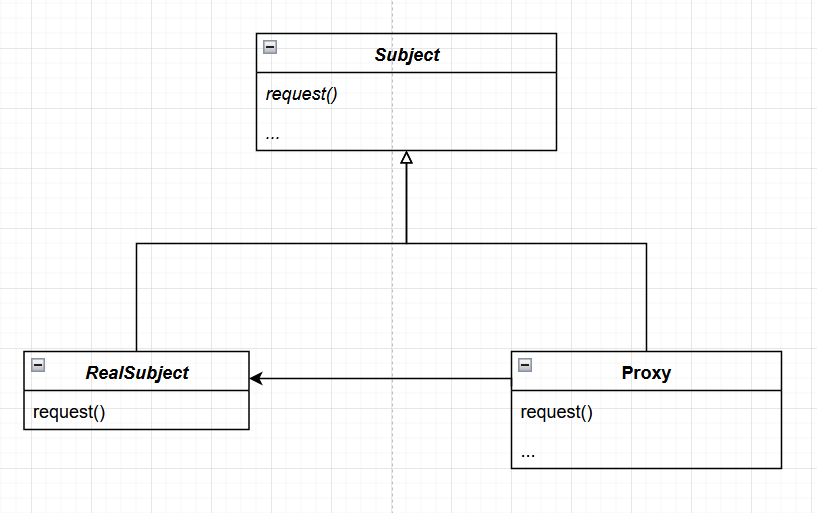

### Problem - kosztowne tworzenie obiektów

Masz edytor graficzny wyświetlający dokument z obrazami. Każdy obraz to **100 MB**.

Dokument ma 50 obrazów = **5 GB** do załadowania przy starcie!

**Problem:** Użytkownik nie przegląda wszystkich obrazów - po co ładować je od razu?

### Naiwne podejście - ładowanie wszystkiego od razu

In [ ]:
class Image:
    def __init__(self, filename):
        self.filename = filename
        self.load_from_disk()  # ❌ Ładuje od razu!
    
    def load_from_disk(self):
        print(f"⏳ Ładowanie {self.filename} z dysku... (kosztowne!)")
        # Symulacja: czytanie 100 MB
    
    def display(self):
        print(f"🖼️  Wyświetlam {self.filename}")

In [ ]:
# Dokument z 3 obrazami
print("Tworzenie dokumentu...")
images = [
    Image("photo1.jpg"),  # Ładuje od razu
    Image("photo2.jpg"),  # Ładuje od razu
    Image("photo3.jpg"),  # Ładuje od razu
]

print("\nUżytkownik przewija do photo2...")
images[1].display()  # Używamy tylko photo2!

**Problem:**
- ❌ **Wszystkie 3 obrazy załadowane** przy tworzeniu dokumentu
- ❌ Użytkownik widzi tylko `photo2` - **2 obrazy załadowane bez potrzeby**!
- ❌ **Długi czas startu** aplikacji
- ❌ **Marnotrawstwo pamięci**

### Rozwiązanie - wzorzec Proxy (Virtual Proxy)

**Idea:** Stwórz **zastępczy obiekt** (proxy), który ładuje prawdziwy obraz **dopiero gdy potrzebny**.

### Krok 1: Wspólny interfejs (Subject)

In [ ]:
from abc import ABC, abstractmethod

class ImageInterface(ABC):
    """Wspólny interfejs dla prawdziwego obrazu i proxy"""
    
    @abstractmethod
    def display(self):
        pass

### Krok 2: Prawdziwy obiekt (RealSubject)

In [ ]:
class RealImage(ImageInterface):
    """Prawdziwy obraz - kosztowny do utworzenia"""
    
    def __init__(self, filename):
        self.filename = filename
        self.load_from_disk()  # Kosztowne ładowanie
    
    def load_from_disk(self):
        print(f"⏳ Ładowanie {self.filename} z dysku... (kosztowne!)")
    
    def display(self):
        print(f"🖼️  Wyświetlam {self.filename}")

### Krok 3: Proxy - leniwe ładowanie

In [ ]:
class ImageProxy(ImageInterface):
    """Proxy - tworzy RealImage dopiero gdy potrzebny"""
    
    def __init__(self, filename):
        self.filename = filename
        self._real_image = None  # Jeszcze nie załadowany!
    
    def display(self):
        # Leniwa inicjalizacja - ładuj tylko gdy wywołano display()
        if self._real_image is None:
            self._real_image = RealImage(self.filename)  # Teraz ładujemy!
        
        # Deleguj do prawdziwego obrazu
        self._real_image.display()

**Kluczowy mechanizm:**
- Proxy **NIE ładuje** obrazu w `__init__()`
- Ładuje dopiero w `display()` - **leniwa inicjalizacja**
- Po załadowaniu **deleguje** wywołanie do `RealImage`

### Krok 4: Użycie - oszczędność zasobów

In [ ]:
# Dokument z 3 obrazami (używamy proxy)
print("Tworzenie dokumentu...")
images = [
    ImageProxy("photo1.jpg"),  # ✅ Nie ładuje!
    ImageProxy("photo2.jpg"),  # ✅ Nie ładuje!
    ImageProxy("photo3.jpg"),  # ✅ Nie ładuje!
]
print("Dokument utworzony (bez ładowania obrazów!)\n")

print("Użytkownik przewija do photo2...")
images[1].display()  # Teraz dopiero ładuje photo2!

print("\nUżytkownik znowu patrzy na photo2...")
images[1].display()  # Już załadowany - nie ładuje ponownie

**Zalety:**
- ✅ **Szybki start** - dokument utworzony natychmiast
- ✅ **Leniwe ładowanie** - tylko `photo2` załadowany
- ✅ **Oszczędność pamięci** - 66% oszczędności (1 obraz zamiast 3)
- ✅ **Transparentność** - klient nie widzi różnicy (`ImageInterface`)

## Typy Proxy

**1. Virtual Proxy (leniwa inicjalizacja)**
- Tworzy obiekt dopiero gdy potrzebny
- Przykład: obrazy w edytorze

**2. Protection Proxy (kontrola dostępu)**
- Sprawdza uprawnienia przed dostępem
- Przykład: dostęp do plików (read-only vs read-write)

**3. Remote Proxy**
- Reprezentuje obiekt w innej przestrzeni adresowej (sieć)
- Przykład: RPC, REST API

**4. Smart Reference**
- Dodaje dodatkowe operacje
- Przykład: licznik referencji, cache, logowanie

## Przykład 2 - Protection Proxy (kontrola dostępu)

In [ ]:
from abc import ABC, abstractmethod

# ════════════════════════════════════════════════════════════
# Interfejs
# ════════════════════════════════════════════════════════════
class Document(ABC):
    @abstractmethod
    def read(self):
        pass
    
    @abstractmethod
    def write(self, content):
        pass


# ════════════════════════════════════════════════════════════
# RealSubject - prawdziwy dokument
# ════════════════════════════════════════════════════════════
class RealDocument(Document):
    def __init__(self, content):
        self.content = content
    
    def read(self):
        return self.content
    
    def write(self, content):
        self.content = content
        print(f"✍️  Zapisano: {content}")


# ════════════════════════════════════════════════════════════
# Proxy - kontrola dostępu
# ════════════════════════════════════════════════════════════
class ProtectedDocument(Document):
    def __init__(self, content: str, user_role: str):
        self._real_document = RealDocument(content)
        self.user_role = user_role  # "admin" lub "guest"
    
    def read(self):
        # Wszyscy mogą czytać
        return self._real_document.read()
    
    def write(self, content):  # walidacja
        # Tylko admin może pisać
        if self.user_role == "admin":
            self._real_document.write(content)
        else:
            print("🚫 Brak uprawnień do zapisu!")

In [ ]:
# Admin - pełny dostęp
admin_doc = ProtectedDocument("Poufne dane", "admin")
print("Admin czyta:", admin_doc.read())
admin_doc.write("Nowa zawartość")

print()

# Guest - tylko odczyt
guest_doc = ProtectedDocument("Poufne dane", "guest")
print("Guest czyta:", guest_doc.read())
guest_doc.write("Próba zapisu")  # Zablokowane!

**Proxy kontroluje dostęp:**
- `read()` - przepuszcza dla wszystkich
- `write()` - sprawdza `user_role` przed delegacją

## Przykład 3 - Smart Reference (cache)

In [ ]:
from abc import ABC, abstractmethod
import time

# ════════════════════════════════════════════════════════════
# Interfejs
# ════════════════════════════════════════════════════════════
class Database(ABC):
    @abstractmethod
    def query(self, sql):
        pass


# ════════════════════════════════════════════════════════════
# RealSubject - prawdziwa baza danych
# ════════════════════════════════════════════════════════════
class RealDatabase(Database):
    def query(self, sql):
        print(f"⏳ Wykonuję zapytanie: {sql}...")
        time.sleep(1)  # Symulacja wolnego zapytania
        return f"Wynik dla: {sql}"


# ════════════════════════════════════════════════════════════
# Proxy - cache
# ════════════════════════════════════════════════════════════
class CachedDatabase(Database):
    def __init__(self):
        self._real_database = RealDatabase()
        self._cache = {}  # Cache wyników
    
    def query(self, sql):
        # Sprawdź cache
        if sql in self._cache:
            print(f"💾 Zwracam z cache: {sql}")
            return self._cache[sql]
        
        # Nie ma w cache - deleguj do prawdziwej bazy
        result = self._real_database.query(sql)
        
        # Zapisz w cache
        self._cache[sql] = result
        return result

In [ ]:
# Proxy z cache
db = CachedDatabase()

print("Pierwsze zapytanie (wolne):")
db.query("SELECT * FROM users")

print("\nDrugie zapytanie (z cache - szybkie):")
db.query("SELECT * FROM users")

print("\nInne zapytanie (wolne):")
db.query("SELECT * FROM products")

## Struktura wzorca

**Elementy wzorca Proxy:**

1. **Subject** - `ImageInterface`, `Document`, `Database`
   - Wspólny interfejs dla RealSubject i Proxy

2. **RealSubject** - `RealImage`, `RealDocument`, `RealDatabase`
   - Prawdziwy obiekt wykonujący pracę
   - Kosztowny do utworzenia lub chroniony

3. **Proxy** - `ImageProxy`, `ProtectedDocument`, `CachedDatabase`
   - Zastępczy obiekt
   - Kontroluje dostęp do RealSubject
   - Deleguje do RealSubject (gdy odpowiedni moment)

**Kluczowa właściwość:**
> Proxy i RealSubject implementują **ten sam interfejs** → klient nie widzi różnicy

## Kiedy używać wzorca Proxy?

Wzorzec Proxy stosuj gdy:

1. **Virtual Proxy - kosztowne tworzenie obiektów**
   - Obiekty duże lub wolno tworzone
   - Chcesz odłożyć tworzenie (lazy initialization)

2. **Protection Proxy - kontrola dostępu**
   - Różne uprawnienia dla różnych użytkowników
   - Walidacja przed dostępem

3. **Remote Proxy - obiekt w innej przestrzeni**
   - Obiekt na innym serwerze/procesie
   - Ukrycie komunikacji sieciowej

4. **Smart Reference - dodatkowa logika**
   - Licznik referencji
   - Cache
   - Logowanie
   - Blokady (locking)

**Przykłady praktyczne:**
- Obrazy w edytorze (virtual proxy)
- Kontrola dostępu do plików (protection proxy)
- ORM - lazy loading relacji (virtual proxy)
- REST API client (remote proxy)
- Database connection pool (smart reference)

## Proxy vs Dekorator vs Adapter

**Wszystkie trzy używają kompozycji, ale mają różne cele:**

| Wzorzec | Cel | Interfejs | Przykład |
|---------|-----|-----------|----------|
| **Proxy** | Kontrola dostępu | Ten sam | Leniwe ładowanie obrazów |
| **Dekorator** | Dodawanie funkcjonalności | Ten sam | Kawa + mleko + czekolada |
| **Adapter** | Dopasowanie interfejsów | Różny | USB-C → USB-A |

**Proxy:**
```python
proxy = ImageProxy("photo.jpg")
proxy.display()  # Proxy kontroluje KIEDY i CZY utworzyć RealImage
```

**Dekorator:**
```python
coffee = Coffee()
coffee = Milk(coffee)
coffee.cost()  # Dekorator DODAJE funkcjonalność
```

**Adapter:**
```python
adapter = USBAdapter(usb_c_device)
adapter.usb_a_method()  # Adapter TŁUMACZY interfejs
```

## Podsumowanie

Wzorzec Proxy:
- ✅ **Kontroluje dostęp** do obiektu (lazy loading, uprawnienia, cache)
- ✅ **Ten sam interfejs** co obiekt rzeczywisty (transparentność)
- ✅ **Oszczędność zasobów** (pamięć, czas, sieć)
- ✅ **Separacja odpowiedzialności** (kontrola vs logika biznesowa)
- ⚠️ **Dodatkowa warstwa** - może zwiększyć złożoność

**Kluczowa idea:**
> **Zastępczy obiekt** kontroluje dostęp do rzeczywistego obiektu

**Struktura:**
- **Subject** - wspólny interfejs
- **RealSubject** - prawdziwy obiekt (kosztowny/chroniony)
- **Proxy** - kontrola dostępu + delegacja do RealSubject

**Formuła:**
```python
class Proxy(Subject):
    def __init__(self):
        self._real_subject = None  # Jeszcze nie istnieje
    
    def operation(self):
        # Kontrola dostępu / leniwa inicjalizacja / cache
        if self._real_subject is None:
            self._real_subject = RealSubject()  # Twórz gdy potrzeba
        
        # Delegacja
        return self._real_subject.operation()
```

**Istota wzorca:**
- **Kontrola:** Proxy decyduje KIEDY i CZY delegować do RealSubject
- **Transparentność:** Klient używa Proxy jak RealSubject (ten sam interfejs)
- **Delegacja:** Proxy przekazuje pracę do RealSubject (po wykonaniu kontroli)